In [1]:
import pandas as pd
import numpy as np
import os
import warnings
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from tqdm import tqdm
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import (
    f1_score, accuracy_score, recall_score, precision_score, 
    precision_recall_curve, confusion_matrix, roc_auc_score, 
    matthews_corrcoef, roc_curve
)

warnings.filterwarnings("ignore")


### 📊 Metric Calculation Utilities


In [2]:

def get_aupr(pre, rec):
    pr_value = 0.0
    for ii in range(len(rec[:-1])):
        x_r, x_l = rec[ii], rec[ii+1]
        y_t, y_b = pre[ii], pre[ii+1]
        tempo = abs(x_r - x_l) * (y_t + y_b) * 0.5
        pr_value += tempo
    return pr_value

def scores(y_test, y_pred, th=0.5):           
    y_predlabel = [(0. if item < th else 1.) for item in y_pred]
    tn, fp, fn, tp = confusion_matrix(y_test, y_predlabel).flatten()
    SPE = tn / (tn + fp)
    MCC = matthews_corrcoef(y_test, y_predlabel)
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    sen, spe, pre, f1, mcc, acc, auc, tn, fp, fn, tp = np.array([
        recall_score(y_test, y_predlabel), SPE, precision_score(y_test, y_predlabel), 
        f1_score(y_test, y_predlabel), MCC, accuracy_score(y_test, y_predlabel), 
        roc_auc_score(y_test, y_pred), tn, fp, fn, tp
    ])
    precision, recall, _ = precision_recall_curve(y_test, y_pred)
    aupr = get_aupr(precision, recall)
    return [aupr, auc, f1, acc, sen, spe, pre, fpr, tpr, precision, recall]


# --- Utility Functions ---

In [3]:
def combine_features(phage_dna, host_dna, phage_pro, host_pro):
    combined = np.concatenate([phage_dna, host_dna, phage_pro, host_pro], axis=1)
    return combined

In [4]:
def load_feature_vector(file_path):
    return np.loadtxt(file_path)

In [5]:
def obtain_features(phage_list, host_list, labels, dna_base, pro_base):
    X_phage_dna, X_host_dna = [], []
    X_phage_pro, X_host_pro = [], []
    for p, h in zip(phage_list, host_list):
        X_phage_dna.append(load_feature_vector(os.path.join(dna_base, 'phage_dna_norm_features', f'{p}.txt')))
        X_host_dna.append(load_feature_vector(os.path.join(dna_base, 'host_dna_norm_features', f'{h}.txt')))
        X_phage_pro.append(load_feature_vector(os.path.join(pro_base, 'phage', f'{p}.txt')))
        X_host_pro.append(load_feature_vector(os.path.join(pro_base, 'bacteria', f'{h}.txt')))
    return (np.array(X_phage_dna), np.array(X_host_dna),
            np.array(X_phage_pro), np.array(X_host_pro),
            np.array(labels))

# --- Load interaction matrix ---

In [6]:
interaction_matrix_path = "./phage_host_interactions (1).csv"
dna_base = './dna_features'
pro_base = './protein_features'

# Get list of phages and hosts based on files present
df = pd.read_csv(interaction_matrix_path, index_col=0)

valid_phages = set([f.split('.')[0] for f in os.listdir(dna_base+"/phage_dna_norm_features") if f.endswith('.txt')])
valid_hosts = set([f.split('.')[0] for f in os.listdir(pro_base+"/bacteria") if f.endswith('.txt')])

df = df.loc[df.index.intersection(valid_hosts), df.columns.intersection(valid_phages)]
#TODO: filter unused interaction since matrix to large

phages = df.columns.tolist()
hosts = df.index.tolist()
print(len(phages))
print(len(hosts))

105
200


# Prepare data as list of (phage, host, label)

In [7]:
all_data = []

for p in phages:
    for h in hosts:
        label = df.loc[h, p]  # Corrected access
        if pd.isna(label):
            continue  # Skip missing values
        all_data.append([p, h, int(label)])

### 🧪 Model Training and Evaluation (with Metrics)

In [21]:

results_all = []
fprs, tprs, precisions, recalls = [], [], [], []
# Your cross-validation setup:
kf = KFold(n_splits=5, random_state=1, shuffle=True)
    
for fold, (train_idx, val_idx) in enumerate(kf.split(all_data)):
    print(f"Fold {fold+1}")
    
    train_set = [all_data[i] for i in train_idx]
    val_set = [all_data[i] for i in val_idx]

    train_phages = [x[0] for x in train_set]
    train_hosts = [x[1] for x in train_set]
    train_labels = [x[2] for x in train_set]

    val_phages = [x[0] for x in val_set]
    val_hosts = [x[1] for x in val_set]
    val_labels = [x[2] for x in val_set]

    X_phage_dna_tr, X_host_dna_tr, X_phage_pro_tr, X_host_pro_tr, y_train = obtain_features(
        train_phages, train_hosts, train_labels, dna_base, pro_base)
    X_phage_dna_val, X_host_dna_val, X_phage_pro_val, X_host_pro_val, y_val = obtain_features(
        val_phages, val_hosts, val_labels, dna_base, pro_base)

    X_train_combined = combine_features(X_phage_dna_tr, X_host_dna_tr, X_phage_pro_tr, X_host_pro_tr)
    X_val_combined = combine_features(X_phage_dna_val, X_host_dna_val, X_phage_pro_val, X_host_pro_val)

    imbalance = sum([1 for i in y_train if i==1]) / sum([1 for i in y_train if i==0])


    model = XGBClassifier(
        scale_pos_weight=1/imbalance,
        learning_rate=0.3,
        n_estimators=250,
        max_depth=7,
        use_label_encoder=False,
        eval_metric='logloss',
        n_jobs=8
    )
    model.fit(X_train_combined, y_train)
    y_pred_prob = model.predict_proba(X_val_combined)[:,1]

    fold_metrics = scores(y_val, y_pred_prob)
    results_all.append(fold_metrics[:7])  # Save base metrics
    fprs.append(fold_metrics[7])
    tprs.append(fold_metrics[8])
    precisions.append(fold_metrics[9])
    recalls.append(fold_metrics[10])

    print(f"Fold {fold+1} | AUPR: {fold_metrics[0]:.4f}, AUC: {fold_metrics[1]:.4f}, F1: {fold_metrics[2]:.4f}, Acc: {fold_metrics[3]:.4f}")


Fold 1


Exception ignored on calling ctypes callback function: <bound method DataIter._next_wrapper of <xgboost.data.SingleBatchInternalIter object at 0x0000025422D01480>>
Traceback (most recent call last):
  File "D:\Bachelorarbeit\Prediction Notebooks\.venv2\lib\site-packages\xgboost\core.py", line 640, in _next_wrapper
    return self._handle_exception(lambda: int(self.next(input_data)), 0)
  File "D:\Bachelorarbeit\Prediction Notebooks\.venv2\lib\site-packages\xgboost\core.py", line 553, in _handle_exception
    return fn()
  File "D:\Bachelorarbeit\Prediction Notebooks\.venv2\lib\site-packages\xgboost\core.py", line 640, in <lambda>
    return self._handle_exception(lambda: int(self.next(input_data)), 0)
  File "D:\Bachelorarbeit\Prediction Notebooks\.venv2\lib\site-packages\xgboost\data.py", line 1654, in next
    input_data(**self.kwargs)
  File "D:\Bachelorarbeit\Prediction Notebooks\.venv2\lib\site-packages\xgboost\core.py", line 729, in inner_f
    return func(**kwargs)
  File "D:\Ba

Fold 1 | AUPR: 0.2053, AUC: 0.7564, F1: 0.2737, Acc: 0.9655
Fold 2
Fold 2 | AUPR: 0.4361, AUC: 0.8058, F1: 0.4272, Acc: 0.9705
Fold 3
Fold 3 | AUPR: 0.3103, AUC: 0.8227, F1: 0.4330, Acc: 0.9725
Fold 4
Fold 4 | AUPR: 0.2924, AUC: 0.7381, F1: 0.3469, Acc: 0.9680
Fold 5
Fold 5 | AUPR: 0.3579, AUC: 0.7549, F1: 0.4000, Acc: 0.9685


### 📉 Plotting Metrics Across Folds

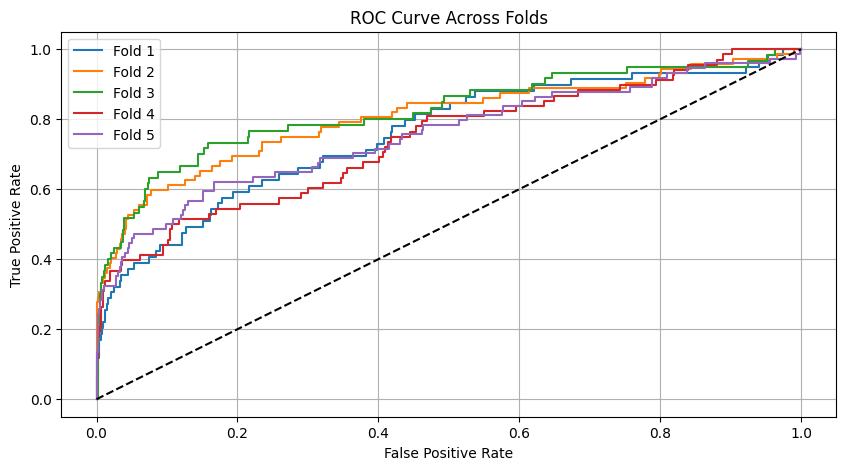

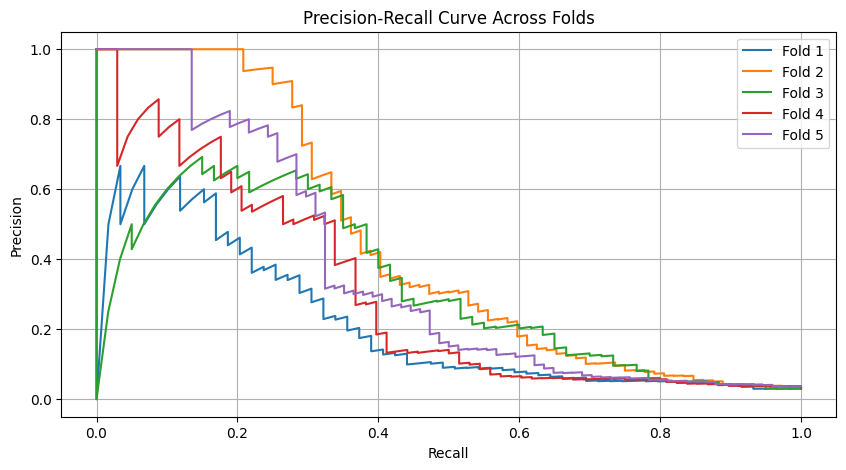

In [9]:


# Plot ROC Curves
plt.figure(figsize=(10, 5))
for i in range(len(fprs)):
    plt.plot(fprs[i], tprs[i], label=f'Fold {i+1}')
plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Curve Across Folds")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid()
plt.show()

# Plot PR Curves
plt.figure(figsize=(10, 5))
for i in range(len(precisions)):
    plt.plot(recalls[i], precisions[i], label=f'Fold {i+1}')
plt.title("Precision-Recall Curve Across Folds")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.grid()
plt.show()


### 📦 Summary Boxplot of All Metrics

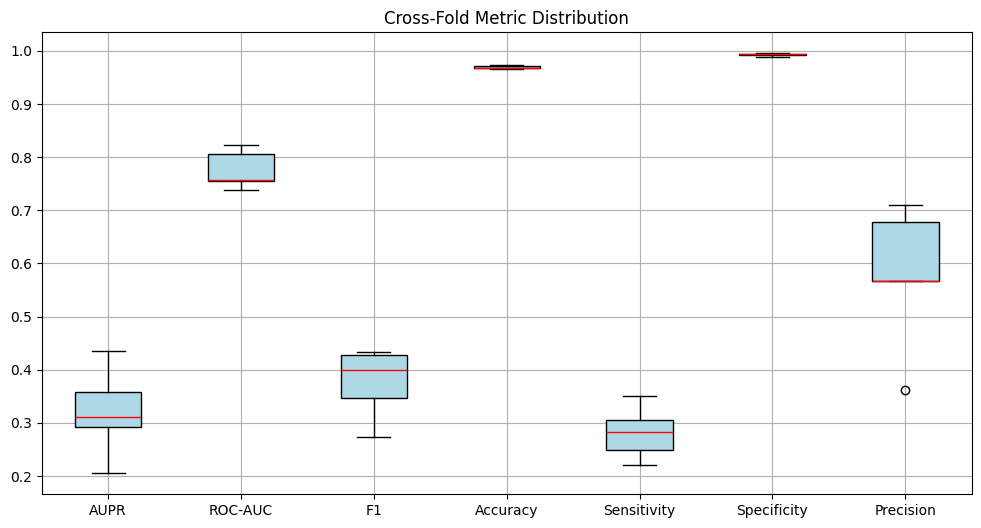

In [10]:

metric_names = ["AUPR", "ROC-AUC", "F1", "Accuracy", "Sensitivity", "Specificity", "Precision"]
results_array = np.array(results_all)

plt.figure(figsize=(12, 6))
plt.boxplot(results_array, labels=metric_names, patch_artist=True,
            boxprops=dict(facecolor='lightblue', color='black'),
            medianprops=dict(color='red'),
            whiskerprops=dict(color='black'))
plt.title("Cross-Fold Metric Distribution")
plt.grid()
plt.show()


### 📋 Fold-wise Metric Table


In [11]:

results_df = pd.DataFrame(results_all, columns=metric_names)
results_df.index = [f"Fold {i+1}" for i in range(len(results_all))]
display(results_df)

print("Mean Metrics:")
display(results_df.mean())


,AUPR,ROC-AUC,F1,Accuracy,Sensitivity,Specificity,Precision
Fold 1,0.205312,0.756370,0.273684,0.965534,0.220339,0.988163,0.361111
Fold 2,0.436058,0.805793,0.427184,0.970515,0.305556,0.995334,0.709677
Fold 3,0.310329,0.822746,0.432990,0.972514,0.350000,0.991757,0.567568
Fold 4,0.292393,0.738124,0.346939,0.968016,0.250000,0.993275,0.566667
Fold 5,0.357870,0.754926,0.400000,0.968516,0.283784,0.994811,0.677419


Mean Metrics:


AUPR           0.320392
ROC-AUC        0.775592
F1             0.376159
Accuracy       0.969019
Sensitivity    0.281936
Specificity    0.992668
Precision      0.576488
dtype: float64

## 🌲 Random Forest Model with Grid SearchCV


In [12]:

rf_results_all = []
rf_fprs, rf_tprs, rf_precisions, rf_recalls = [], [], [], []

rf_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['auto', 'sqrt', 'log2'],
    'bootstrap': [True, False]
}

for fold, (train_idx, val_idx) in enumerate(kf.split(all_data)):
    print(f"RF Fold {fold+1}")

    train_set = [all_data[i] for i in train_idx]
    val_set = [all_data[i] for i in val_idx]

    train_phages = [x[0] for x in train_set]
    train_hosts = [x[1] for x in train_set]
    train_labels = [x[2] for x in train_set]

    val_phages = [x[0] for x in val_set]
    val_hosts = [x[1] for x in val_set]
    val_labels = [x[2] for x in val_set]

    X_phage_dna_tr, X_host_dna_tr, X_phage_pro_tr, X_host_pro_tr, y_train = obtain_features(
        train_phages, train_hosts, train_labels, dna_base, pro_base)
    X_phage_dna_val, X_host_dna_val, X_phage_pro_val, X_host_pro_val, y_val = obtain_features(
        val_phages, val_hosts, val_labels, dna_base, pro_base)

    X_train_combined = combine_features(X_phage_dna_tr, X_host_dna_tr, X_phage_pro_tr, X_host_pro_tr)
    X_val_combined = combine_features(X_phage_dna_val, X_host_dna_val, X_phage_pro_val, X_host_pro_val)
    
    class_weights = compute_class_weight(class_weight='balanced', classes=np.array([0, 1]), y=y_train)
    class_weight_dict = {0: class_weights[0], 1: class_weights[1]}
    
    rf_base = RandomForestClassifier(class_weight=class_weight_dict, random_state=42, n_jobs=-1)
    grid_search = GridSearchCV(estimator=rf_base, param_grid=rf_param_grid, 
                               scoring='f1', cv=3, n_jobs=-1, verbose=0)
    grid_search.fit(X_train_combined, y_train)
    best_rf = grid_search.best_estimator_

    y_pred_prob = best_rf.predict_proba(X_val_combined)[:, 1]

    rf_fold_metrics = scores(y_val, y_pred_prob)
    rf_results_all.append(rf_fold_metrics[:7])
    rf_fprs.append(rf_fold_metrics[7])
    rf_tprs.append(rf_fold_metrics[8])
    rf_precisions.append(rf_fold_metrics[9])
    rf_recalls.append(rf_fold_metrics[10])

    print(f"Fold {fold+1} | AUPR: {rf_fold_metrics[0]:.4f}, AUC: {rf_fold_metrics[1]:.4f}, "
          f"F1: {rf_fold_metrics[2]:.4f}, Acc: {rf_fold_metrics[3]:.4f}")


RF Fold 1
Fold 1 | AUPR: 0.1528, AUC: 0.7708, F1: 0.2553, Acc: 0.9650
RF Fold 2
Fold 2 | AUPR: 0.2967, AUC: 0.7781, F1: 0.3580, Acc: 0.9480
RF Fold 3
Fold 3 | AUPR: 0.2531, AUC: 0.8121, F1: 0.2597, Acc: 0.9715
RF Fold 4
Fold 4 | AUPR: 0.1722, AUC: 0.7137, F1: 0.2424, Acc: 0.9375
RF Fold 5
Fold 5 | AUPR: 0.3326, AUC: 0.7834, F1: 0.3371, Acc: 0.9410


### 🌲 Random Forest ROC & PR Curves

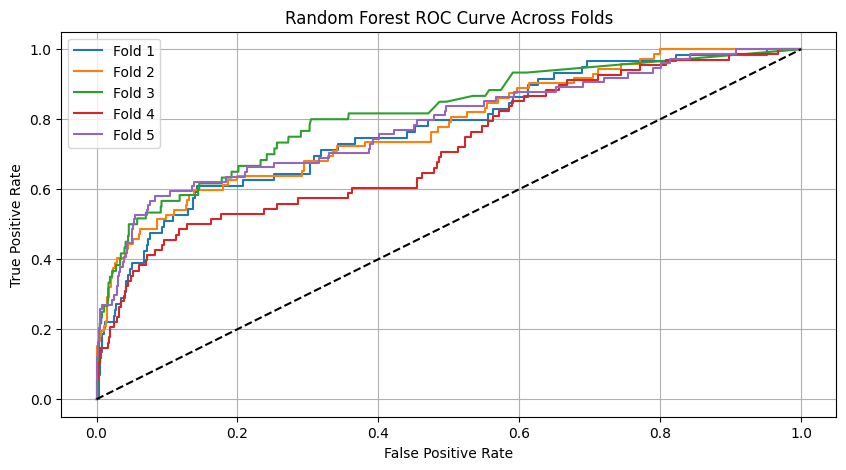

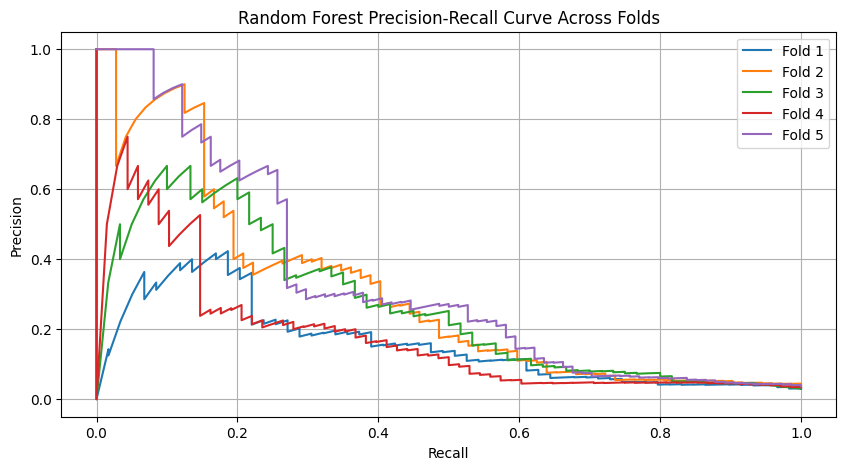

In [13]:

plt.figure(figsize=(10, 5))
for i in range(len(rf_fprs)):
    plt.plot(rf_fprs[i], rf_tprs[i], label=f'Fold {i+1}')
plt.plot([0, 1], [0, 1], 'k--')
plt.title("Random Forest ROC Curve Across Folds")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(10, 5))
for i in range(len(rf_precisions)):
    plt.plot(rf_recalls[i], rf_precisions[i], label=f'Fold {i+1}')
plt.title("Random Forest Precision-Recall Curve Across Folds")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.grid()
plt.show()


### 📦 Metric Boxplot: XGBoost vs Random Forest

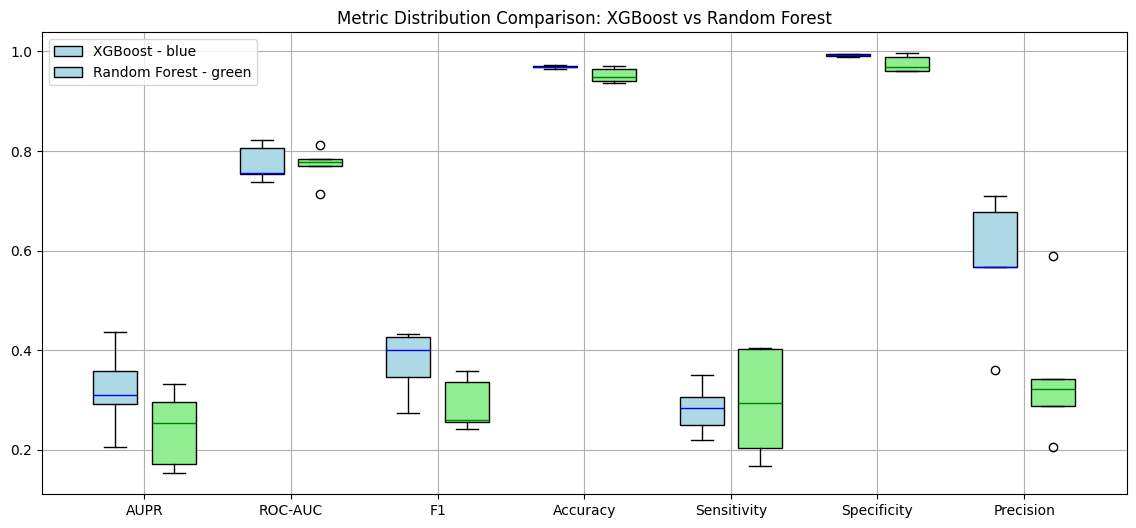

In [14]:

all_metric_names = ["AUPR", "ROC-AUC", "F1", "Accuracy", "Sensitivity", "Specificity", "Precision"]

plt.figure(figsize=(14, 6))
plt.boxplot([np.array(results_all)[:,i] for i in range(7)], 
            positions=np.arange(1, 8) - 0.2, widths=0.3, patch_artist=True,
            boxprops=dict(facecolor='lightblue'), medianprops=dict(color='blue'), labels=all_metric_names)

plt.boxplot([np.array(rf_results_all)[:,i] for i in range(7)], 
            positions=np.arange(1, 8) + 0.2, widths=0.3, patch_artist=True,
            boxprops=dict(facecolor='lightgreen'), medianprops=dict(color='green'))

plt.legend(['XGBoost - blue', 'Random Forest - green'])
plt.title("Metric Distribution Comparison: XGBoost vs Random Forest")
plt.grid()
plt.xticks(np.arange(1, 8), all_metric_names)
plt.show()


### 📋 Random Forest Fold-wise Metrics

In [15]:

rf_df = pd.DataFrame(rf_results_all, columns=all_metric_names)
rf_df.index = [f"Fold {i+1}" for i in range(len(rf_results_all))]
display(rf_df)

print("Random Forest - Mean Metrics:")
display(rf_df.mean())


,AUPR,ROC-AUC,F1,Accuracy,Sensitivity,Specificity,Precision
Fold 1,0.152843,0.770798,0.255319,0.965035,0.203390,0.988163,0.342857
Fold 2,0.296718,0.778087,0.358025,0.948026,0.402778,0.968377,0.322222
Fold 3,0.253124,0.812142,0.259740,0.971514,0.166667,0.996394,0.588235
Fold 4,0.172177,0.713741,0.242424,0.937531,0.294118,0.960166,0.206186
Fold 5,0.332612,0.783447,0.337079,0.941029,0.405405,0.961598,0.288462


Random Forest - Mean Metrics:


AUPR           0.241495
ROC-AUC        0.771643
F1             0.290517
Accuracy       0.952627
Sensitivity    0.294471
Specificity    0.974940
Precision      0.349592
dtype: float64

### 📊 Side-by-side Mean Metrics (XGBoost vs RF)

In [16]:

xgb_mean = pd.DataFrame([np.mean(results_all, axis=0)], columns=all_metric_names, index=["XGBoost"])
rf_mean = pd.DataFrame([np.mean(rf_results_all, axis=0)], columns=all_metric_names, index=["Random Forest"])

display(pd.concat([xgb_mean, rf_mean]))


,AUPR,ROC-AUC,F1,Accuracy,Sensitivity,Specificity,Precision
XGBoost,0.320392,0.775592,0.376159,0.969019,0.281936,0.992668,0.576488
Random Forest,0.241495,0.771643,0.290517,0.952627,0.294471,0.974940,0.349592


# XGBoost with LOGO

In [17]:

# Assuming:
# all_data = [(phage, host, label), ...]
# hosts = list of host IDs
# phages = list of phage IDs

# Create groups based on host for LOGO
groups = []
for sample in all_data:
    phage, host, label = sample
    group_id = hosts.index(host)  # group by host
    groups.append(group_id)

print(f"Number of unique groups (hosts): {len(set(groups))}")


Number of unique groups (hosts): 200


In [18]:


logo = LeaveOneGroupOut()
cpus = 8

# For collecting predictions and labels
scores_all = []
label_list = []

# Progress bar for number of groups
pbar = tqdm(total=len(set(groups)))

for fold, (train_idx, val_idx) in enumerate(logo.split(all_data, groups=groups)):
    # Prepare data
    train_set = [all_data[i] for i in train_idx]
    val_set = [all_data[i] for i in val_idx]

    train_phages = [x[0] for x in train_set]
    train_hosts = [x[1] for x in train_set]
    train_labels = [x[2] for x in train_set]

    val_phages = [x[0] for x in val_set]
    val_hosts = [x[1] for x in val_set]
    val_labels = [x[2] for x in val_set]

    # Obtain features
    X_phage_dna_tr, X_host_dna_tr, X_phage_pro_tr, X_host_pro_tr, y_train = obtain_features(train_phages, train_hosts, train_labels, dna_base, pro_base)
    X_phage_dna_val, X_host_dna_val, X_phage_pro_val, X_host_pro_val, y_val = obtain_features(val_phages, val_hosts, val_labels, dna_base, pro_base)


    # Combine features for train and val
    X_train_combined = combine_features(X_phage_dna_tr, X_host_dna_tr, X_phage_pro_tr, X_host_pro_tr)
    X_val_combined = combine_features(X_phage_dna_val, X_host_dna_val, X_phage_pro_val, X_host_pro_val,)

    # Class imbalance handling
    pos = sum(y_train)
    neg = len(y_train) - pos
    scale_pos_weight = neg / pos if pos > 0 else 1

    # Train
    model = XGBClassifier(
        scale_pos_weight=scale_pos_weight,
        learning_rate=0.3,
        n_estimators=250,
        max_depth=7,
        use_label_encoder=False,
        eval_metric='logloss',
        n_jobs=cpus
    )
    model.fit(X_train_combined, y_train)

    # Predict
    y_pred_prob = model.predict_proba(X_val_combined)[:, 1]
    scores_all.append(y_pred_prob)
    label_list.append(y_val)

    pbar.update(1)

pbar.close()

# Concatenate all predictions and labels
y_pred_all = np.concatenate(scores_all)
y_true_all = np.concatenate(label_list)

# Now evaluate final performance
final_metrics = scores(y_true_all, y_pred_all)

print("\nFinal LOGO metrics across all folds:")
print(f"AUPR: {final_metrics[0]:.4f}, AUC: {final_metrics[1]:.4f}, F1: {final_metrics[2]:.4f}, Accuracy: {final_metrics[3]:.4f}")


 72%|███████▏  | 144/200 [33:41<13:39, 14.63s/it]
KeyboardInterrupt

